In [164]:
import torch
import torch.nn as nn
import torch.utils.data
import numpy as np
from presentation import *
import pandas as pd
import matplotlib
import sys

print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.6.0+cu101


In [165]:
train_data = pd.read_csv('E:/data/house_price_prediction/train.csv')
test_data = pd.read_csv('E:/data/house_price_prediction/test.csv')

In [166]:
train_data.shape
# 训练集包含1460个样本，80个特征，1个标签

(1460, 81)

In [167]:
test_data.shape
# 测试集包含1459个样本，80个特征

(1459, 80)

In [168]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]
# 查看前4个样本的前4个特征，后2个特征和标签

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [169]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
# 不适用第一个特征id，将后面79个特征按样本联结
all_features.shape

(2919, 79)

In [170]:
# 数据预处理
# 对连续数值的特征做标准化处理
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# 将lambda构造的匿名函数通过apply运用到数组的各行各列中
all_features[numeric_features] = all_features[numeric_features].apply(
                                lambda x : (x - x.mean()) / (x.std()))
# 将缺失值用0代替
all_features = all_features.fillna(0)

In [171]:
# 对离散数据处理，转换成指示特征
# panda.get_dummies:实现one hot encode功能
# dummy_na = True将缺失值也当做合法的特征值并为其创建指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 354)

In [172]:
# 处理数据,通过values得到numpy格式的数据
# 得到训练数据和测试数据
n_train = train_data.shape[0]

train_features = torch.tensor(all_features[:n_train].values, 
                              dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, 
                             dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values,
                            dtype=torch.float).view(-1, 1)

In [173]:
# 设计训练模型
# 损失函数
loss = torch.nn.MSELoss()

# 线性回归模型
def get_net(features_num):
    net = nn.Linear(features_num, 1)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

In [174]:
# 误差函数：对数均方根误差
def log_rmse(net, features, labels):
    with torch.no_grad():
        # 将小于1的值设成1，使得取对数时数值更稳定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.item()

In [175]:
# 训练
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, batch_size, weight_decay):
    
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    net = net.float()
    
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()),y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [176]:
# k折交叉验证
# 将数据集分成K个不重合的子数据集，每次选择一个作为验证集，其余K-1个作为训练集
def get_k_fold_data(k, i, X, y):
    # 返回第i折交叉验证时所需的训练和验证数据
    assert k > 1
    # 计算每次交叉验证的数据大小
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part),dim=0)
            y_train = torch.cat((y_train, y_part),dim=0)
    return X_train, y_train, X_valid, y_valid

In [177]:
def k_hold(k, X_train, y_train, 
           num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data,
                                  num_epochs, learning_rate, batch_size, weight_decay)
        
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                   range(1, num_epochs + 1), valid_ls, ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k
        

fold 0, train rmse 0.240151, valid rmse 0.219939
fold 1, train rmse 0.229484, valid rmse 0.268986
fold 2, train rmse 0.232006, valid rmse 0.238153
fold 3, train rmse 0.237739, valid rmse 0.218627
fold 4, train rmse 0.230992, valid rmse 0.258828
5-fold validation: avg train rmse 0.234074, avg valid rmse 0.240906


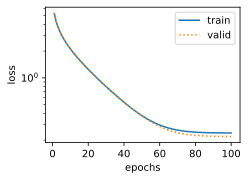

In [178]:
# 选择模型并运行
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_hold(k, train_features, train_labels,
                          num_epochs, lr, weight_decay, batch_size)
print("%d-fold validation: avg train rmse %f, avg valid rmse %f" %
      (k, train_l, valid_l))


In [ ]:
# 测试,采用完整训练集训练（不适用验证集）

def train_and_pred(train_features, test_features, train_labels, test_data,
                  num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, test_features, None,
          num_epochs, learning_rate, batch_size, weight_decay)
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % (train_ls[-1]))
    preds = net(test_features).detach().numpy()
    test_data['Saleprice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv()
